<a href="https://colab.research.google.com/github/faizyabShah/VisualQA/blob/main/VisualQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Ummmm, DL project ig*

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/lhanhsin/vizwiz")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faizyabalishah
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/lhanhsin/vizwiz


100%|██████████| 17.5G/17.5G [03:41<00:00, 84.8MB/s]


In [ ]:
!pip install ftfy regex tqdm
!pip install pandas
!pip install wordcloud
!pip install sklearn
!pip install scikit-learn
!pip install Levenshtein
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 758.7 kB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a1i_b_m4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a1i_b_m4
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f0

*Imports*

In [ ]:
%pip install python-Levenshtein==0.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 881.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: Insecure, upgrade to 0.12.1
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp310-cp310-linux_x86_64.whl size=155437 sha256=b514d9e8ec92c2d15c0363cb73c019606659144947330ce2c036a8751f44c105
  Stored in directory: /root/.cache/pip/wheels/64/9d/d4/b0f4b842be0e66baad0fdf1b91dd90b36b4135feefc8dfae55
Successfully built python-Levenshtein


In [ ]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=c55d207fb65d7dab8eb32906cafc21582bad7dcf266748e09254697166c06e5a
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
!pip install ftfy==5.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 953.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ftfy: filename=ftfy-5.4.1-py3-none-any.whl size=42862 sha256=57558f503e0314a90ff18579aa47f03cecb7e6dda4dc4b746b8c9feed1882f53
  Stored in directory: /root/.cache/pip/wheels/a4/91/4b/87bb696a4f23e5a661792b300cc920b35aa8f3a0f7e3a83a92
Successfully built ftfy
  Attempting uninstall: ftfy
    Found existing installation: ftfy 6.2.0
    Uninstalling ftfy-6.2.0:
      Successfully uninstalled ftfy-6.2.0


In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

import requests

from sklearn.metrics import average_precision_score

import json

*Configure*

In [ ]:
# Configuring the paths for the dataset
INPUT_PATH = '/content/vizwiz'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/content/output/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cpu


*Pandas stuff*

In [ ]:
def read_dataframe(path):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def split_train_test(dataframe, test_size = 0.05):
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe(dataframe):
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

*Creating dataframes*

In [ ]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


In [ ]:
print(train_df)

                           image  \
14709  VizWiz_train_00014709.jpg   
9566   VizWiz_train_00009566.jpg   
11322  VizWiz_train_00011322.jpg   
5267   VizWiz_train_00005267.jpg   
9281   VizWiz_train_00009281.jpg   
...                          ...   
15453  VizWiz_train_00015453.jpg   
19967  VizWiz_train_00019967.jpg   
17226  VizWiz_train_00017226.jpg   
16495  VizWiz_train_00016495.jpg   
8401   VizWiz_train_00008401.jpg   

                                                question  \
14709                                      What is this?   
9566   What product is this? Is it moisturizing lotion?    
11322                                What's in this box?   
5267             What is in this kitchen?  In this room?   
9281                    Is this shampoo or conditioner?    
...                                                  ...   
15453                              What number is shown?   
19967                                        Where is B?   
17226                      

*Training dataframes*

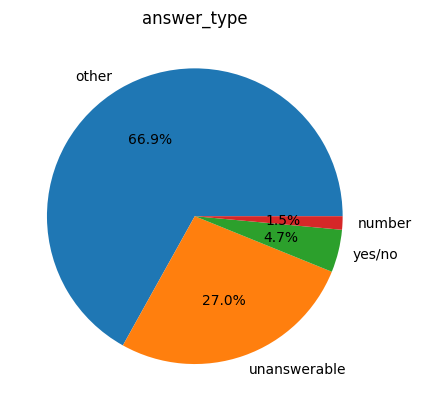

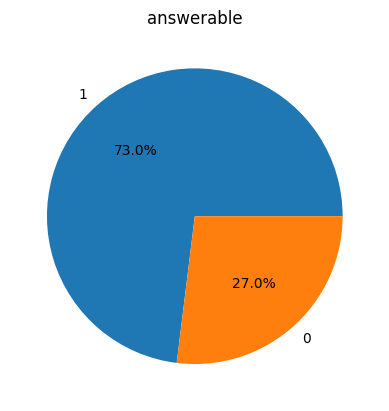

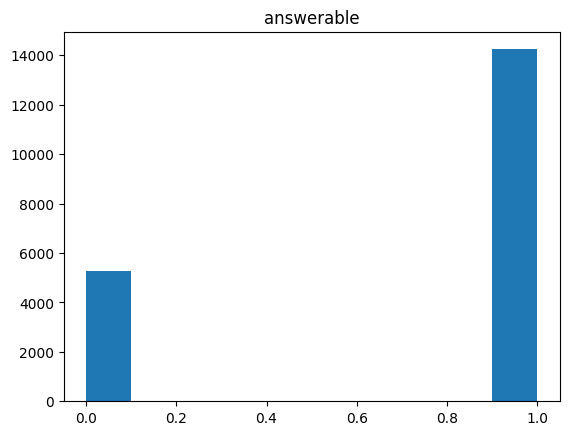

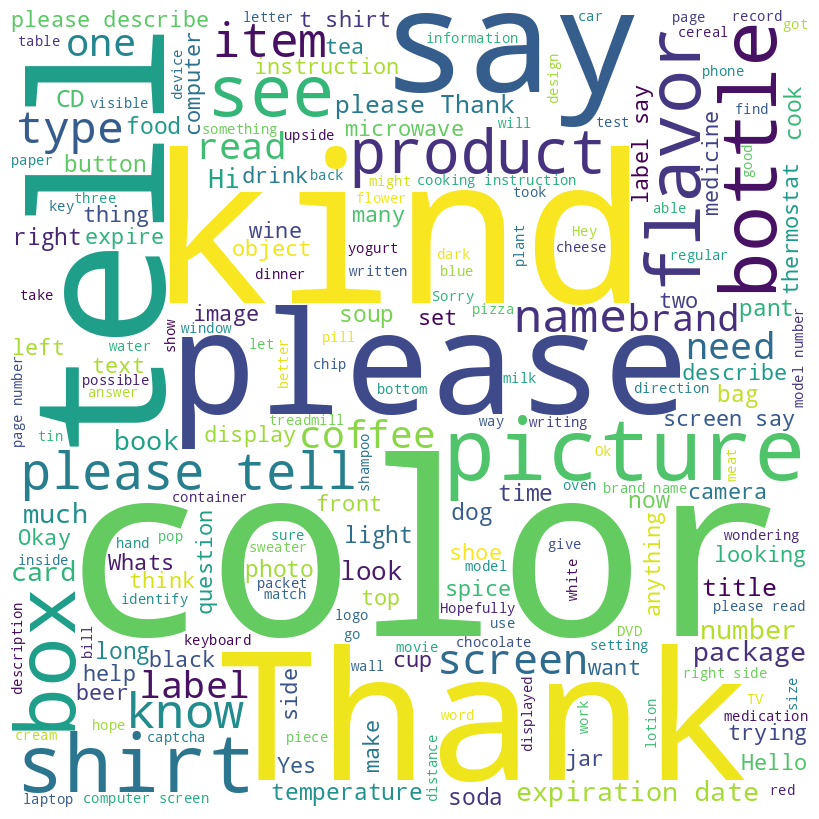

In [ ]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

*Validation dataframes*

Number of distinct answers:  39515
Number of samples in train:  19496


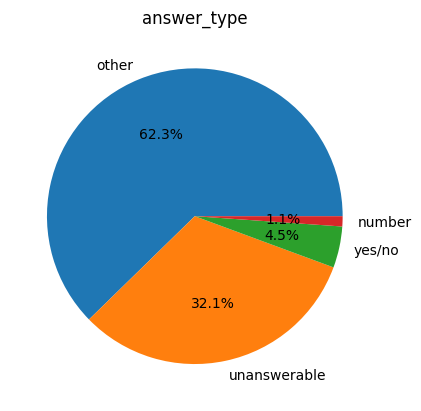

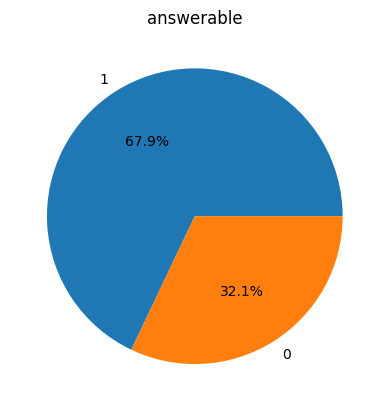

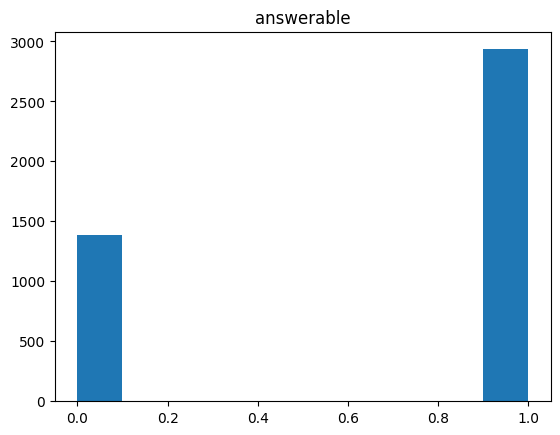

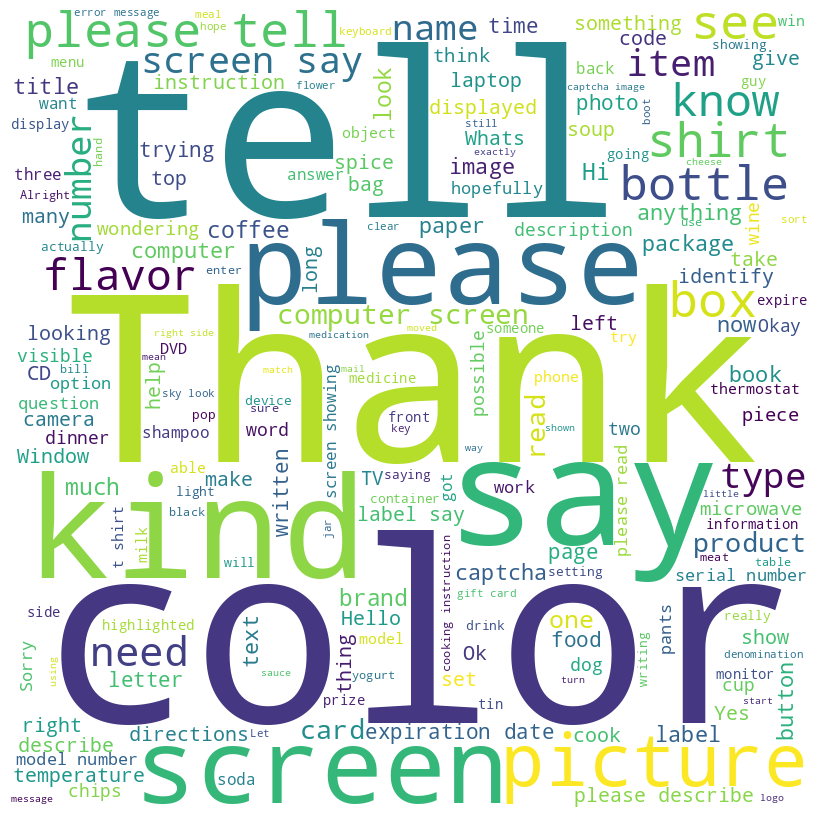

Number of distinct answers:  10905
Number of samples in validation set:  4319


In [ ]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

*Testing dataframes*

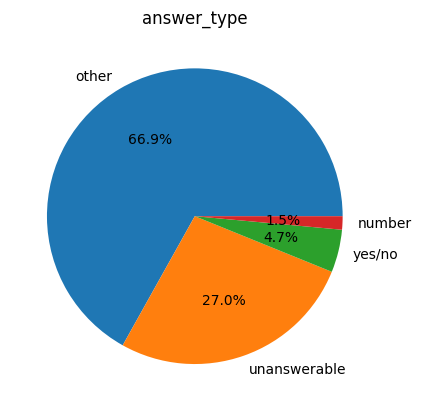

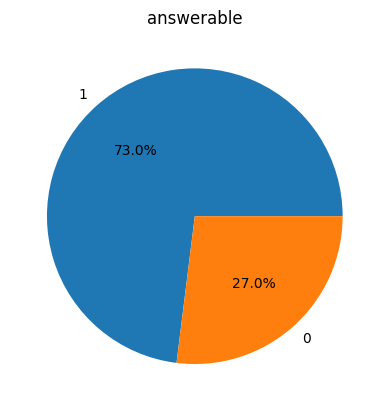

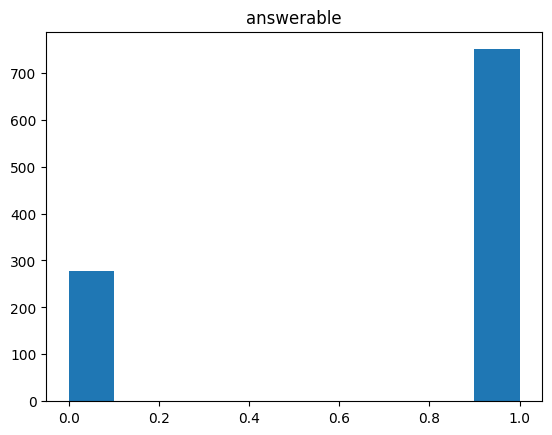

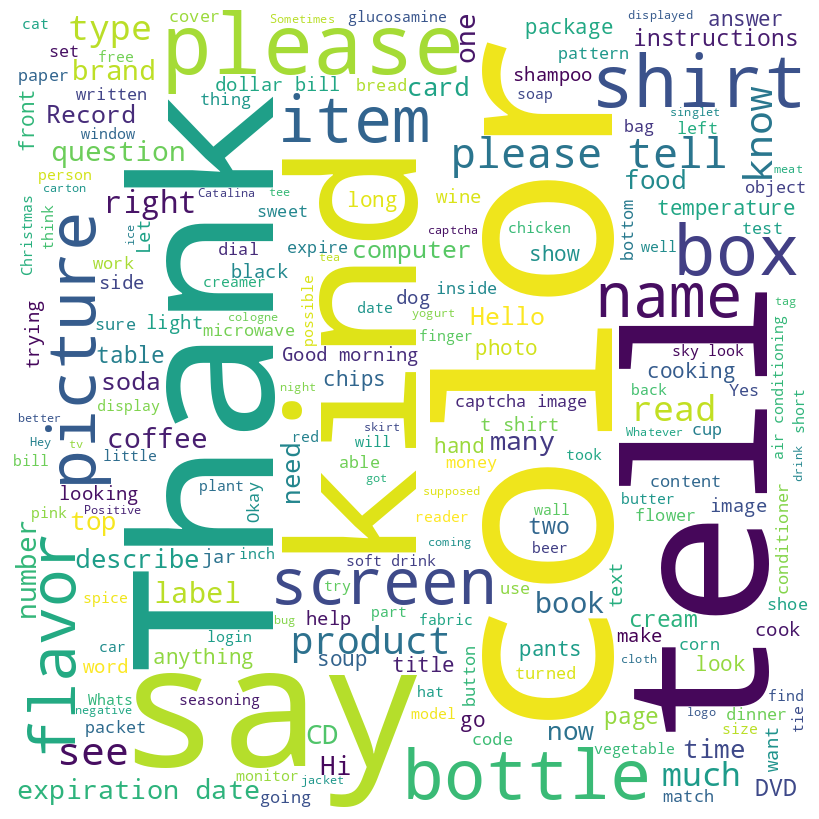

Number of distinct answers:  3007
Number of samples in test:  1027


In [ ]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

*Processing images and questions with clip*

In [ ]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

100%|███████████████████████████████████████| 891M/891M [00:11<00:00, 79.8MiB/s]


*Dataset class*

In [ ]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, answer_type_onehotencoder = None, answer_onehotencoder = None, model_name = "RN50x64", images_features = torch.tensor([]), questions_features = torch.tensor([])):
        super(VizWizDataset, self).__init__()

        self.answer_counter = Counter()

        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()
        self.dataframe = dataframe

        self.answer_counter_per_question = []
        self.build_answer_counter()

        self.build_answer_vocab()

        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])

        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])

        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()

        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        self.build_answer_counter_per_question()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return self.images_features[index], self.questions_features[index], answer, answer_type, answer_counter, answerable

    def build_answer_counter_per_question(self):

        for index, row in self.dataframe.iterrows():
            temp_list = []
            for answer_map in row['answers']:
                answer = answer_map['answer']
                if answer in self.answers_categories:
                    answer_index = self.answers_categories.index(answer)
                    temp_list.append(answer_index)
            while len(temp_list) < 10:
                temp_list.append(-1)
            self.answer_counter_per_question.append(temp_list)



    def build_answer_vocab(self):
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])

    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()

*Model*

In [ ]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, hidden_2, hidden_3, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.training_answerability = []
        self.validation_answerability = []

        self.device = device
        self.model_name = model_name

        self.answerability_loss_fn = nn.BCELoss()

        self.clip_model, self.preprocess = clip.load(model_name, device = device)

        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.2),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, hidden_2)
        )

        self.linear_layer3 = nn.Sequential(
            nn.LayerNorm(hidden_2),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_2, hidden_3)
        )

        self.linear_layer4 = nn.Sequential(
            nn.LayerNorm(hidden_3),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_3, num_classes)
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        self.answerability_final_layer = nn.Linear(hidden_size, 1)

        self.answerability_sigmoid = nn.Sigmoid()

    def forward(self, image, question):

        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)

        answerability_score = self.answerability_linear_layer(features)
        answerability_score = self.answerability_final_layer(answerability_score)
        answerability_score = self.answerability_sigmoid(answerability_score)
        answerability_score = answerability_score.squeeze()

        features = self.linear_layer1(features)

        answer_type = self.answer_type_layer(features)

        answer_mask = self.answer_mask_layer(answer_type)

        answer_mask = self.sigmoid(answer_mask)

        output = self.linear_layer2(features)
        output = self.linear_layer3(output)
        output = self.linear_layer4(output)

        output = output * answer_mask

        return output, answer_type, answerability_score

    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy, train_answerability_score = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy, validation_answerability_score = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy, test_answerability_score = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)

            self.training_answerability.append(train_answerability_score)
            self.validation_answerability.append(validation_answerability_score)


            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))
            print("Epoch: {} | Training Answerability Score: {:.3f} | Validation Answerability Score: {:.3f} | Test Answerability Score: {:.3f}\n".format(epoch, train_answerability_score, validation_answerability_score, test_answerability_score))

            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
        return

    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)
            answerable = 1 - answerable
            answerable_predict = 1.0 - answerable_predict
            loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                answerable_true.append(answerable[i].item())
                answerable_predicted.append(answerable_predict[i].item())


        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return training_loss, training_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')


    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)

                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return validation_loss, validation_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        plt.plot(self.training_answerability, label = "Training Answerability")
        plt.plot(self.validation_answerability, label = "Validation Answerability")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: copy the folder /content/drive/MyDrive/vqa-data  into colab

!cp -r /content/drive/MyDrive/vqa_data /content/


*Loading embeddings*

In [ ]:
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

*Preparing dataloader*

In [ ]:
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5410
Number of distinct answers:  1531
Number of distinct answers:  489


*Training*

Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch: 1 | Training Loss: 6.954 | Validation Loss: 4.100
Epoch: 1 | Training Accuracy: 0.241 | Validation Accuracy: 0.337 | Test Accuracy: 0.345
Epoch: 1 | Training VizWiz Accuracy: 0.369 | Validation VizWiz Accuracy: 0.471 | Test VizWiz Accuracy: 0.487
Epoch: 1 | Training Answerability Score: 0.701 | Validation Answerability Score: 0.810 | Test Answerability Score: 0.797

Epoch: 2 | Training Loss: 6.216 | Validation Loss: 3.761
Epoch: 2 | Training Accuracy: 0.275 | Validation Accuracy: 0.358 | Test Accuracy: 0.387
Epoch: 2 | Training VizWiz Accuracy: 0.396 | Validation VizWiz Accuracy: 0.493 | Test VizWiz Accuracy: 0.541
Epoch: 2 | Training Answerability Score: 0.748 | Validation Answerability Score: 0.813 | Test Answerability Score: 0.805

Epoch: 3 | Training Loss: 5.691 | Validation Loss: 3.428
Epoch: 3 | Training Accuracy: 0.301 | Validation Accuracy: 0.382 | Tes

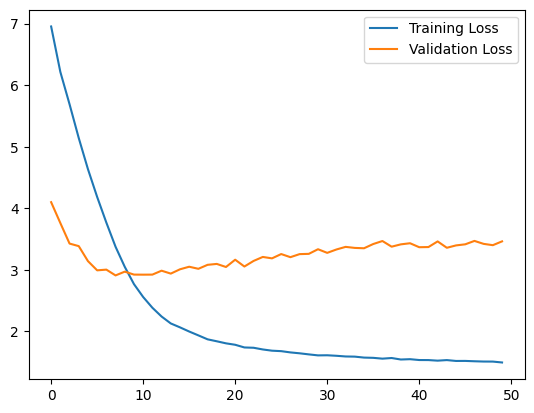

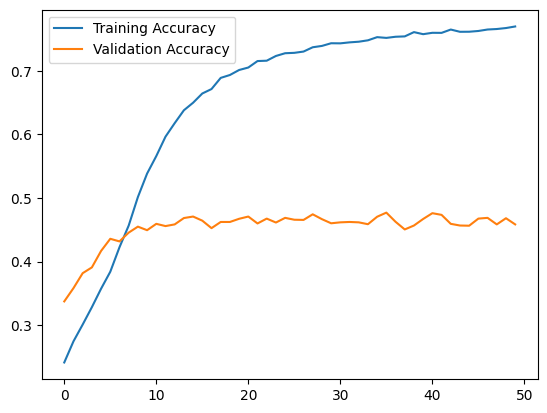

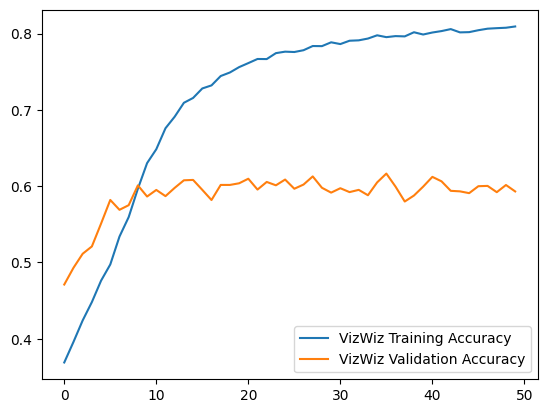

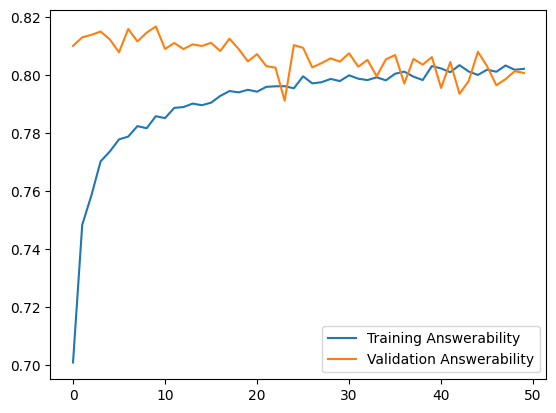

In [ ]:
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 5

model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()

*Saving the model*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

model.save_model('/content/drive/MyDrive/vqa_data/vqamodel.pt')


In [ ]:
!cp -r output/answer_onehotencoder.pkl /content/drive/MyDrive/vqa_data
!cp -r output/answer_type_onehotencoder.pkl /content/drive/MyDrive/vqa_data
!cp -r output/training_images.pkl /content/drive/MyDrive/vqa_data
!cp -r output/training_questions.pkl /content/drive/MyDrive/vqa_data
!cp -r output/validation_images.pkl /content/drive/MyDrive/vqa_data
!cp -r output/validation_questions.pkl /content/drive/MyDrive/vqa_data
!cp -r output/test_images.pkl /content/drive/MyDrive/vqa_data
!cp -r output/test_questions.pkl /content/drive/MyDrive/vqa_data


*Testing own image*

In [ ]:
QUESTION = "How many objects are there in this image?"
IMAGE_PATH = "/content/own_imgs/three.jpg"

with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
NUM_CLASSES = len(training_dataset.get_answer_vocab())

predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = IMAGE_PATH, question = QUESTION)
answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())

# Printing the answer and answer type
print("The Answer is: " + answer[0][0])
print("The Answer Type is: " + answer_type[0][0])
print("The confidence for being unanswerable: " + str(answerability.item()))